In [1]:
import numpy as np
import os
import sys
from six.moves import cPickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.layers import Conv2D, Activation, BatchNormalization, Input, Dropout
from keras.layers import AveragePooling2D, Flatten, MaxPooling2D, Dense
from keras.models import Model
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

Using TensorFlow backend.


In [2]:
num_classes = 10
batch_size = 16
epochs = 250
steps_per_epoch =  int(40000/batch_size)

In [3]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 60:
        lrate = 0.005
    if epoch > 120:
        lrate = 0.003
    if epoch > 180:
        lrate = 0.001
    return lrate

train_x shape: (40000, 32, 32, 3)
40000 train samples


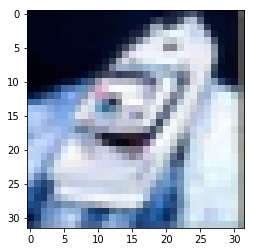

In [4]:
def load_data():
    # Modify path string. use your path which your dataset is in
    path =  r'C:\Users\strea\Links\baseline_code_final (2)'
    fpath = os.path.join(path, 'train_data')
    
    with open(fpath, 'rb') as f:
        d = cPickle.load(f, encoding='bytes')
    X_train = d['data']
    y_train = d['labels']
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32) # 3072개 숫자가 한줄로 이어진 배열 하나를 32x32짜리 배열 3개로 만듦
    X_train = X_train.transpose(0, 2, 3, 1)
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

train_x, train_y = load_data()
print('train_x shape:', train_x.shape)
print(train_x.shape[0], 'train samples')
plt.imshow(train_x[2])
plt.show()

In [5]:
# random state는 전체 데이터셋에서 train set의 비율을 의미함 0~1 사이의 값을 입력함
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, random_state=0)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((30000, 32, 32, 3), (10000, 32, 32, 3), (30000, 10), (10000, 10))

In [6]:
def simple_net(x,kernel_size=32, dropsize=0.2):
    for i in range(3):
        x = Conv2D(kernel_size,(3,3), padding='same')(x)
        x = Activation('relu')(x)
        x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(dropsize)(x)
    return x

In [7]:
inputs = Input(shape=x_train.shape[1:]) # 텐서로 만들어줌
x = simple_net(inputs)
x = simple_net(x,kernel_size=64, dropsize=0.3)
x = simple_net(x,kernel_size=128, dropsize=0.4)
x = simple_net(x,kernel_size=256, dropsize=0.5)
x = AveragePooling2D(pool_size=2)(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activat

In [8]:
# opt_rms = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)    
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss:.4f}.h5'

In [10]:
checkpoint = ModelCheckpoint(filepath=modelpath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
callbacks = [checkpoint, lr_scheduler]

In [11]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

datagen.fit(x_train)

In [12]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              epochs=epochs,
                              steps_per_epoch=steps_per_epoch,
                              workers=4,
                              validation_data=(x_test, y_test),
                              callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/250
2500/2500 [==============================] - 97s 39ms/step - loss: 1.7471 - acc: 0.3906 - val_loss: 1.6007 - val_acc: 0.5046

Epoch 00001: val_loss improved from inf to 1.60065, saving model to ./model/01-1.6007.h5
Epoch 2/250
2500/2500 [==============================] - 92s 37ms/step - loss: 1.2870 - acc: 0.5412 - val_loss: 1.1443 - val_acc: 0.6042

Epoch 00002: val_loss improved from 1.60065 to 1.14434, saving model to ./model/02-1.1443.h5
Epoch 3/250
2500/2500 [==============================] - 91s 37ms/step - loss: 1.0806 - acc: 0.6213 - val_loss: 0.9799 - val_acc: 0.6631

Epoch 00003: val_loss improved from 1.14434 to 0.97988, saving model to ./model/03-0.9799.h5
Epoch 4/250
2500/2500 [==============================] - 93s 37ms/step - loss: 0.9484 - acc: 0.6733 - val_loss: 0.8411 - val_acc: 0.7096

Epoch 00004: val_loss improved from 0.97988 to 0.84105, saving model to ./model/04-0.8411.h5
Epoch 5/250
2500/2500 [=========

2500/2500 [==============================] - 94s 38ms/step - loss: 0.3315 - acc: 0.8844 - val_loss: 0.3780 - val_acc: 0.8803

Epoch 00039: val_loss improved from 0.39699 to 0.37797, saving model to ./model/39-0.3780.h5
Epoch 40/250
2500/2500 [==============================] - 94s 37ms/step - loss: 0.3267 - acc: 0.8863 - val_loss: 0.4017 - val_acc: 0.8734

Epoch 00040: val_loss did not improve from 0.37797
Epoch 41/250
2500/2500 [==============================] - 94s 37ms/step - loss: 0.3177 - acc: 0.8891 - val_loss: 0.4107 - val_acc: 0.8729

Epoch 00041: val_loss did not improve from 0.37797
Epoch 42/250
2500/2500 [==============================] - 94s 37ms/step - loss: 0.3190 - acc: 0.8887 - val_loss: 0.4034 - val_acc: 0.8719

Epoch 00042: val_loss did not improve from 0.37797
Epoch 43/250
2500/2500 [==============================] - 94s 37ms/step - loss: 0.3094 - acc: 0.8917 - val_loss: 0.3858 - val_acc: 0.8761

Epoch 00043: val_loss did not improve from 0.37797
Epoch 44/250
2500/250

2500/2500 [==============================] - 94s 38ms/step - loss: 0.3651 - acc: 0.8765 - val_loss: 0.6691 - val_acc: 0.8223

Epoch 00082: val_loss did not improve from 0.36495
Epoch 83/250
2500/2500 [==============================] - 94s 37ms/step - loss: 0.3686 - acc: 0.8741 - val_loss: 0.4303 - val_acc: 0.8635

Epoch 00083: val_loss did not improve from 0.36495
Epoch 84/250
2500/2500 [==============================] - 93s 37ms/step - loss: 0.3623 - acc: 0.8769 - val_loss: 0.4520 - val_acc: 0.8639

Epoch 00084: val_loss did not improve from 0.36495
Epoch 85/250
2500/2500 [==============================] - 94s 37ms/step - loss: 0.3625 - acc: 0.8758 - val_loss: 0.4379 - val_acc: 0.8731

Epoch 00085: val_loss did not improve from 0.36495
Epoch 86/250
2500/2500 [==============================] - 94s 37ms/step - loss: 0.3500 - acc: 0.8810 - val_loss: 0.3955 - val_acc: 0.8787

Epoch 00086: val_loss did not improve from 0.36495
Epoch 87/250
2500/2500 [==============================] - 94s 3

2500/2500 [==============================] - 94s 37ms/step - loss: 0.1949 - acc: 0.9313 - val_loss: 0.3693 - val_acc: 0.8992

Epoch 00125: val_loss did not improve from 0.34672
Epoch 126/250
2500/2500 [==============================] - 94s 37ms/step - loss: 0.1885 - acc: 0.9355 - val_loss: 0.3894 - val_acc: 0.8930

Epoch 00126: val_loss did not improve from 0.34672
Epoch 127/250
2500/2500 [==============================] - 94s 37ms/step - loss: 0.1938 - acc: 0.9324 - val_loss: 0.3542 - val_acc: 0.8989

Epoch 00127: val_loss did not improve from 0.34672
Epoch 128/250
2500/2500 [==============================] - 91s 36ms/step - loss: 0.1902 - acc: 0.9329 - val_loss: 0.3399 - val_acc: 0.9032

Epoch 00128: val_loss improved from 0.34672 to 0.33991, saving model to ./model/128-0.3399.h5
Epoch 129/250
2500/2500 [==============================] - 92s 37ms/step - loss: 0.1849 - acc: 0.9354 - val_loss: 0.3412 - val_acc: 0.9023

Epoch 00129: val_loss did not improve from 0.33991
Epoch 130/250
25


Epoch 00167: val_loss did not improve from 0.33226
Epoch 168/250
2500/2500 [==============================] - 93s 37ms/step - loss: 0.1552 - acc: 0.9468 - val_loss: 0.3791 - val_acc: 0.8974

Epoch 00168: val_loss did not improve from 0.33226
Epoch 169/250
2500/2500 [==============================] - 93s 37ms/step - loss: 0.1574 - acc: 0.9454 - val_loss: 0.3597 - val_acc: 0.8997

Epoch 00169: val_loss did not improve from 0.33226
Epoch 170/250
2500/2500 [==============================] - 93s 37ms/step - loss: 0.1431 - acc: 0.9506 - val_loss: 0.4082 - val_acc: 0.8923

Epoch 00170: val_loss did not improve from 0.33226
Epoch 171/250
2500/2500 [==============================] - 94s 37ms/step - loss: 0.1544 - acc: 0.9463 - val_loss: 0.3734 - val_acc: 0.8926

Epoch 00171: val_loss did not improve from 0.33226
Epoch 172/250
2500/2500 [==============================] - 93s 37ms/step - loss: 0.1465 - acc: 0.9497 - val_loss: 0.3749 - val_acc: 0.9004

Epoch 00172: val_loss did not improve from 0


Epoch 00210: val_loss did not improve from 0.33226
Epoch 211/250
2500/2500 [==============================] - 94s 38ms/step - loss: 0.0904 - acc: 0.9686 - val_loss: 0.3505 - val_acc: 0.9110

Epoch 00211: val_loss did not improve from 0.33226
Epoch 212/250
2500/2500 [==============================] - 94s 37ms/step - loss: 0.0909 - acc: 0.9684 - val_loss: 0.3714 - val_acc: 0.9121

Epoch 00212: val_loss did not improve from 0.33226
Epoch 213/250
2500/2500 [==============================] - 94s 37ms/step - loss: 0.0841 - acc: 0.9704 - val_loss: 0.3818 - val_acc: 0.9080

Epoch 00213: val_loss did not improve from 0.33226
Epoch 214/250
2500/2500 [==============================] - 94s 37ms/step - loss: 0.0904 - acc: 0.9691 - val_loss: 0.3545 - val_acc: 0.9108

Epoch 00214: val_loss did not improve from 0.33226
Epoch 215/250
2500/2500 [==============================] - 94s 37ms/step - loss: 0.0886 - acc: 0.9690 - val_loss: 0.3792 - val_acc: 0.9065

Epoch 00215: val_loss did not improve from 0

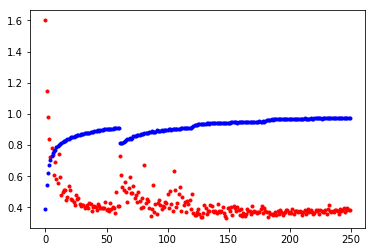

In [13]:
# y_loss에 학습셋으로 실험 결과의 오차 값을 저장
y_vloss = history.history['val_loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()

## 테스트결과

cf) 그래프 추가<br> / adam
batch_size = 100, epochs = 50  keras.optimizers.rmsprop(lr=0.001, decay=1e-6)  -> <b> 옵티마이저 adam </b> 22초 걸림

conv(32,3,3) + elu + batch 3번 + maxpool(2,2) + dropout(0.2)<br>
conv(64,3,3) + elu + batch 3번 + maxpool(2,2) + dropout(0.3)<br>
conv(128,3,3) + elu + batch 3번 + maxpool(3,3) + dropout(0.4)

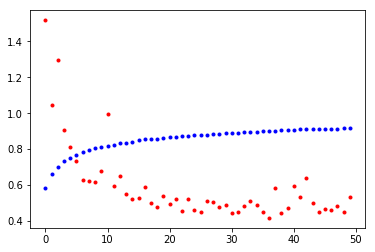

In [15]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 2s 178us/step

Test result: 85.290 loss: 0.533


lr scheduler 추가(0.001 ->0.005(60) ->0.003(120) -> 0.001(180) -> 250  / batch_size = 16, epochs = 250 / adam

conv(32,3,3) + elu + batch 3번 + maxpool(2,2) + dropout(0.2)<br>
conv(64,3,3) + elu + batch 3번 + maxpool(2,2) + dropout(0.3)<br>
conv(128,3,3) + elu + batch 3번 + maxpool(2,2) + dropout(0.4)<br>
conv(256,3,3) + elu + batch 3번 + maxpool(2,2) + dropout(0.5)

In [14]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 2s 204us/step

Test result: 91.130 loss: 0.383
